In [3]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial

from HelperFunctions import TestModels

import jax.numpy as jnp
from jax import config,devices,jit
import jax.scipy.optimize as jax_optimize
print(devices())
# Global flag to set a specific platform, must be used at startup.
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True);

[CpuDevice(id=0)]


The cross entropy of some parameter distribution $\pi({\bf\Theta})$ for parameters ${\bf\Theta}\in\mathbb{R}^P$ reads
$$
\mathcal{C}[\pi]
=
\int \ln\left|\int \rho(E|{\bf X},{\bf\Theta}){\rm d}\pi\right|{\rm d}\rho({\bf X})
$$
With $\rho({\bf X}) = \sum_i{\rm w}_i\delta({\bf X}-{\bf X}_i)$ and 
$\pi({\bf\Theta}) = \sum_j{\rm a}_j\delta({\bf\Theta}-{\bf\Theta}_j)$

$$
\mathcal{C}[\pi]
\simeq
\sum_i
{\rm w}_i
\ln\left|
    \sum_j
    {\rm a}_j
    \exp(-\lambda\|E_i-{\bf D}_i\cdot{\bf\Theta}_j\|^2)
\right|
-\ln\sqrt{2\pi\lambda}
$$

With $M$ models, we can set ${\rm a}_j=1/M$ then consider a minimization problem of $\oplus_j{\bf\Theta}_j\in\mathbb{R}^{MP}$ directly

In [10]:
@jit
def CrossEntropy(T,X,y,sigma_MLE=1.0,epsilon=1.0):
    """Find cross entropy of 
    model ensemble T over data X,y
    M : number of models
    N : number of data
    P : number of parameters

    epsilon scales the width of the Gaussian cost 
    from the MLE standard deviation, i.e.
    sigma = sigma_MLE * epsilon


    Parameters
    ----------
    
    T : (M,P) array
    X : (N,P) array
    y : (N,) array
    sigma_MLE : float, default 1.0
    epsilon: float, default 1.0
    

    Returns
    -------
    Cross entropy, a number
    """
    sigma = sigma_MLE * epsilon 
    # shape (N,M)
    C = jnp.exp(-(X@T.T - y[:,None])**2/sigma**2/2.0)
    C /= jnp.sqrt(2.0*jnp.pi*sigma**2)
    # take uniform weights
    return -jnp.log(C.mean(1)).mean()

In [11]:
# Generate a "fresh" model
M = 500
P = 6

res = TestModels(N_train=M,
                 N_test=M,
                 P=P,
                 seed=121,
                 model='random', 
                 noise=0.0 
                 )

X = jnp.array(res['X_TRAIN'])
y = jnp.array(res['Y_TRAIN'])
Thetas = res['ALL_POINTWISE_FITS'].copy()
Theta_MLE = jnp.array(res['Theta_LST_SQ'])
sigma_mle = (X@Theta_MLE - y).std()

In [12]:
# start with 10% ensemble variance
T_0 = (0.1*(Thetas-Thetas.mean(0)) + Thetas.mean(0)).flatten()
epsilons=[2.0,1.0,0.5]
Thetas_G_E = []
for epsilon in epsilons:
    @jit
    def CrossEntropyFlat(T):
        Cp = partial(CrossEntropy,sigma_MLE=sigma_mle,X=X,y=y,epsilon=epsilon)
        return Cp(T.reshape((-1,P)))
    
    opt = jax_optimize.minimize(CrossEntropyFlat,
                                      T_0,method='BFGS',tol=1e-6)
    print(opt.fun)
    T_0 = opt.x.copy().flatten()
    Thetas_G_E.append(opt.x.copy().reshape((-1,P)))
    rel_std = (Thetas_G_E[-1].std(0)/Thetas.std(0))
    print(f"""
          CrossEnt(epsilon={epsilon}) / Ensemble std: {rel_std}
    """)

0.21391282644472276

          CrossEnt(epsilon=2.0) / Ensemble std: [0.00318935 0.00205025 0.00492252 0.00328285 0.00224908 0.00196569]
    
-0.10585290142223802

          CrossEnt(epsilon=1.0) / Ensemble std: [0.17060573 0.30823352 0.67873072 0.1512868  0.14044281 0.18477359]
    
-0.29976460068664595

          CrossEnt(epsilon=0.5) / Ensemble std: [1.75262834 2.53778437 2.80660809 2.32806001 1.77759517 1.46686982]
    


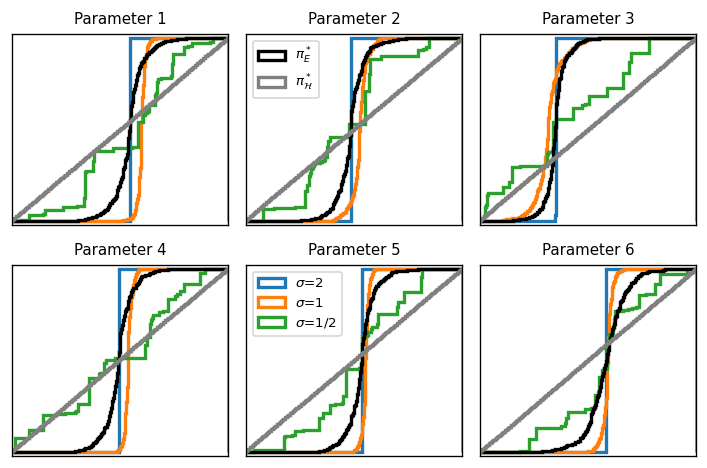

In [20]:
fig,axs = plt.subplots(2,3,figsize=(6,4),sharey="row",dpi=120)
hist = lambda ax,data,bins,color,label,w=None: \
    ax.hist(data,bins=bins,color=color,weights=w,label=label,\
            histtype='step',lw=2,cumulative=True,density=True)
axs = axs.flatten()
for i,ax in enumerate(axs):
     bins = np.linspace(Thetas[:,i].min(),Thetas[:,i].max(),300)
     dbin = bins[1]-bins[0]
     hist(ax,Thetas_G_E[0][:,i],bins,'C0',\
         r'$\sigma$=2' if i==4 else None)
     hist(ax,Thetas_G_E[1][:,i],bins,'C1',\
         r'$\sigma$=1' if i==4 else None)
     hist(ax,Thetas_G_E[2][:,i],bins,'C2',\
         r'$\sigma$=1/2' if i==4 else None)
     
     hist(ax,Thetas[:,i],bins,'k',r'$\pi^*_E$' if i==1 else None,w=res['ALL_POINTWISE_WEIGHTS'])
     h_sample = \
     np.random.uniform(Thetas[:,i].min(),Thetas[:,i].max(),Thetas[:,i].size*100)
     hist(ax,h_sample,bins,'0.5','$\pi^*_{\mathcal{H}}$' if i==1 else None)
     ax.set_xlim(Thetas[:,i].min()+dbin,Thetas[:,i].max()-dbin)
     ax.set_ylim(-0.02,1.02)
     ax.set_yticks([])
     ax.set_xticks([])
     ax.set_title(f'Parameter {i+1}',fontsize=9)
axs[1].legend(fontsize=8,loc='upper left')
axs[4].legend(fontsize=8,loc='upper left')
plt.tight_layout()
plt.savefig('ParameterDistributions.png')

$m_{ij}$ indicates if $\mathcal{E}({\bf X}_j)$ is matched by ${\bf\Theta}_i\cdot{\bf D}_j$
$$
\mathcal{G}_E = -\frac{1}{N}\sum_j\ln|\sum_iw_im_{ij}|
$$
with $\rho_{ij} = m_{ij}/m_j$, $m_j=\sum_im_{ij}$ and $\rho_i=\frac{1}{N}\sum_j\rho_{ij}$ we have 

$$
\mathcal{G}_E 
= -\frac{1}{N}\sum_j\ln|m_j\sum_i w_i\rho_{ij}|
\leq -\frac{1}{N}\sum_j\ln|m_j|+ \mathcal{L}_E
$$

$$
\mathcal{L}_E=
-\sum_{i}\rho_{i}\ln|w_i|
$$

We then minimize 
$$
L=
\mathcal{L}_E+\lambda\sum_i(w_i-1)
=
\sum_{i}
\lambda(w_i-1)
-
\rho_{i}\ln|w_i|
$$

$$
\frac{\partial L}{\partial w_i}
=0
,\quad
\Rightarrow
w_i
=
\frac{\rho_{i}}{\lambda}
$$




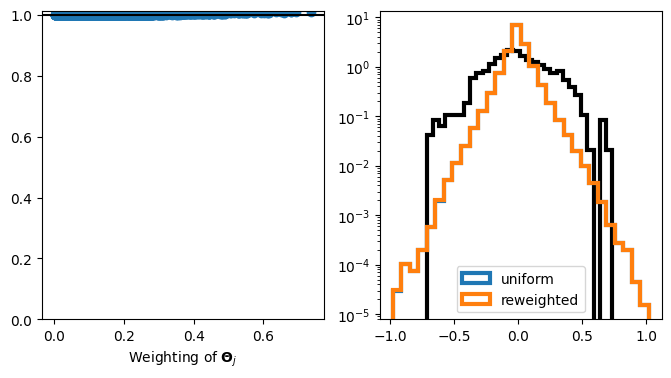

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].scatter(np.abs(X@Thetas.mean(0) - y),weights)
axs[0].axhline(1.0,c='k')
axs[0].set_ylim(ymin=0)

X = jnp.array(res['X_TEST'])
y = jnp.array(res['Y_TEST'])
e = y - X@Thetas.mean(0)

axs[1].hist(e,bins=30,histtype="step",density=True,color='k',lw=3);
full_e = (X@(Thetas-Thetas.mean(0)[None,:]).T) # (N_data,N_ens)
axs[1].hist(full_e.flatten(),bins=30,histtype="step",density=True,label='uniform',lw=3);

w=np.outer(np.ones(X.shape[0]),res['ALL_POINTWISE_WEIGHTS']).flatten()
axs[1].hist(full_e.flatten(),weights=w,bins=30,histtype="step",density=True,label='reweighted',lw=3);
axs[0].set_xlabel(r"MLE Error at ${\bf X}_j$")
axs[0].set_xlabel(r"Weighting of ${\bf\Theta}_j$")

axs[1].legend()
axs[1].set_yscale("log")


